# Deutsch-Jozsa Algorithm: Comprehensive Tutorial

**Team:** Dhinchak Dikstra  
**Project:** AAD Quantum Computing Algorithms

---

## 📚 Table of Contents

1. [Introduction](#intro)
2. [Problem Statement](#problem)
3. [Quantum vs Classical Complexity](#complexity)
4. [Algorithm Implementation](#implementation)
5. [Experiments and Analysis](#experiments)
6. [Conclusions](#conclusions)

---

<a id='intro'></a>
## 1. Introduction

The **Deutsch-Jozsa algorithm** is one of the first examples of a quantum algorithm that demonstrates **exponential speedup** over any deterministic classical algorithm. 

### Key Concepts:
- **Quantum Superposition**: Process qubits in all states simultaneously
- **Quantum Interference**: Use destructive/constructive interference to amplify correct answers
- **Phase Kickback**: Transfer phase information from output to input qubits
- **Oracle Model**: Query a black-box function

### Historical Significance:
- Published by David Deutsch and Richard Jozsa in 1992
- First algorithm to prove quantum computers can outperform classical computers
- Inspired the development of more practical quantum algorithms like Shor's and Grover's

<a id='problem'></a>
## 2. Problem Statement

Given a black-box function:

$$f: \{0,1\}^n \rightarrow \{0,1\}$$

The function is **promised** to be either:

1. **Constant**: $f(x) = c$ for all $x$ (where $c \in \{0,1\}$)
2. **Balanced**: $f(x) = 0$ for exactly half the inputs and $f(x) = 1$ for the other half

### Goal
Determine whether $f$ is **constant** or **balanced** using the minimum number of queries.

### Example (n=2)

**Constant functions:**
- $f(00) = f(01) = f(10) = f(11) = 0$
- $f(00) = f(01) = f(10) = f(11) = 1$

**Balanced functions:**
- $f(00) = f(01) = 0, f(10) = f(11) = 1$
- $f(00) = f(10) = 0, f(01) = f(11) = 1$
- ... (many other combinations)

<a id='complexity'></a>
## 3. Quantum vs Classical Complexity

### Classical Approach

**Deterministic Algorithm:**
- Worst case: $2^{n-1} + 1$ queries
- Must query more than half the inputs to be certain

**Probabilistic Algorithm:**
- $k$ random queries give confidence $1 - (1/2)^{k-1}$
- For 99% confidence: ~7 queries
- Never achieves 100% certainty in finite time

### Quantum Approach

**Deutsch-Jozsa Algorithm:**
- **Exactly 1 query**
- **100% success probability**
- **Exponential speedup**: $\Theta(2^n)$ vs $\Theta(1)$

### Speedup Table

| n | Quantum | Classical (Det.) | Speedup |
|---|---------|------------------|--------|
| 3 | 1 | 5 | 5x |
| 5 | 1 | 17 | 17x |
| 10 | 1 | 513 | 513x |
| 20 | 1 | 524,289 | 524,289x |

<a id='implementation'></a>
## 4. Algorithm Implementation

### Import Libraries

In [14]:
# Quantum computing framework
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import (
    plot_histogram, 
    plot_bloch_multivector,
    circuit_drawer
)

# Scientific computing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("📊 Ready to explore the Deutsch-Jozsa algorithm!")

✅ All libraries imported successfully!
📊 Ready to explore the Deutsch-Jozsa algorithm!


### Algorithm Overview

The Deutsch-Jozsa algorithm follows these steps:

```
|0⟩^⊗n ────H^⊗n──── Oracle ────H^⊗n──── Measure
|1⟩   ────H────────   Uf   ────────────
```

**Step-by-step:**

1. **Initialize**: $|\psi_0\rangle = |0\rangle^{\otimes n} |1\rangle$

2. **Create Superposition**: Apply Hadamard to all qubits
   $$|\psi_1\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}}$$

3. **Query Oracle**: Apply $U_f$
   $$|\psi_2\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}}$$

4. **Interfere**: Apply Hadamard to input qubits
   $$|\psi_3\rangle = \sum_{z=0}^{2^n-1} \alpha_z |z\rangle$$
   
   where $\alpha_0 = \frac{1}{2^n} \sum_{x=0}^{2^n-1} (-1)^{f(x)}$

5. **Measure**: 
   - If $f$ is constant: $\alpha_0 = \pm 1$ → Always measure $|0\rangle^{\otimes n}$
   - If $f$ is balanced: $\alpha_0 = 0$ → Never measure $|0\rangle^{\otimes n}$

### Oracle Construction

An **oracle** is a black-box quantum operation that encodes the function $f$:

$$U_f |x\rangle |y\rangle = |x\rangle |y \oplus f(x)\rangle$$

When the output qubit is in state $(|0\rangle - |1\rangle)/\sqrt{2}$:

$$U_f |x\rangle \frac{|0\rangle - |1\rangle}{\sqrt{2}} = (-1)^{f(x)} |x\rangle \frac{|0\rangle - |1\rangle}{\sqrt{2}}$$

This is called **phase kickback**.

In [15]:
def create_constant_oracle(n_qubits, output_value=0):
    """
    Create an oracle for a constant function.
    
    Args:
        n_qubits: Number of input qubits
        output_value: Constant output (0 or 1)
    
    Returns:
        QuantumCircuit: Oracle circuit
    """
    oracle = QuantumCircuit(n_qubits + 1, name=f'f(x)={output_value}')
    
    if output_value == 1:
        # Flip the output qubit
        oracle.x(n_qubits)
    # If output_value == 0, do nothing (identity)
    
    return oracle

def create_balanced_oracle(n_qubits, oracle_type='xor'):
    """
    Create an oracle for a balanced function.
    
    Args:
        n_qubits: Number of input qubits
        oracle_type: Type of balanced function
            - 'first_bit': f(x) = x_0
            - 'xor': f(x) = x_0 ⊕ x_1 ⊕ ... ⊕ x_{n-1}
            - 'random': random balanced function
    
    Returns:
        QuantumCircuit: Oracle circuit
    """
    oracle = QuantumCircuit(n_qubits + 1, name=f'Balanced({oracle_type})')
    
    if oracle_type == 'first_bit':
        # Function depends only on first qubit
        oracle.cx(0, n_qubits)
    
    elif oracle_type == 'xor':
        # Function is XOR of all input bits
        for i in range(n_qubits):
            oracle.cx(i, n_qubits)
    
    elif oracle_type == 'random':
        # Random balanced function
        num_controls = np.random.randint(1, n_qubits + 1)
        controls = np.random.choice(n_qubits, num_controls, replace=False)
        for control in controls:
            oracle.cx(control, n_qubits)
    
    return oracle

# Test oracle creation
print("Testing Oracle Creation:")
print("=" * 50)

# Constant oracle
oracle_const_0 = create_constant_oracle(3, 0)
print(f"✅ Constant oracle (f(x)=0): {oracle_const_0.num_qubits} qubits")

oracle_const_1 = create_constant_oracle(3, 1)
print(f"✅ Constant oracle (f(x)=1): {oracle_const_1.num_qubits} qubits")

# Balanced oracles
oracle_balanced = create_balanced_oracle(3, 'xor')
print(f"✅ Balanced oracle (XOR): {oracle_balanced.num_qubits} qubits")

print("\n✅ All oracles created successfully!")

Testing Oracle Creation:
✅ Constant oracle (f(x)=0): 4 qubits
✅ Constant oracle (f(x)=1): 4 qubits
✅ Balanced oracle (XOR): 4 qubits

✅ All oracles created successfully!


### Visualize Oracle Circuits

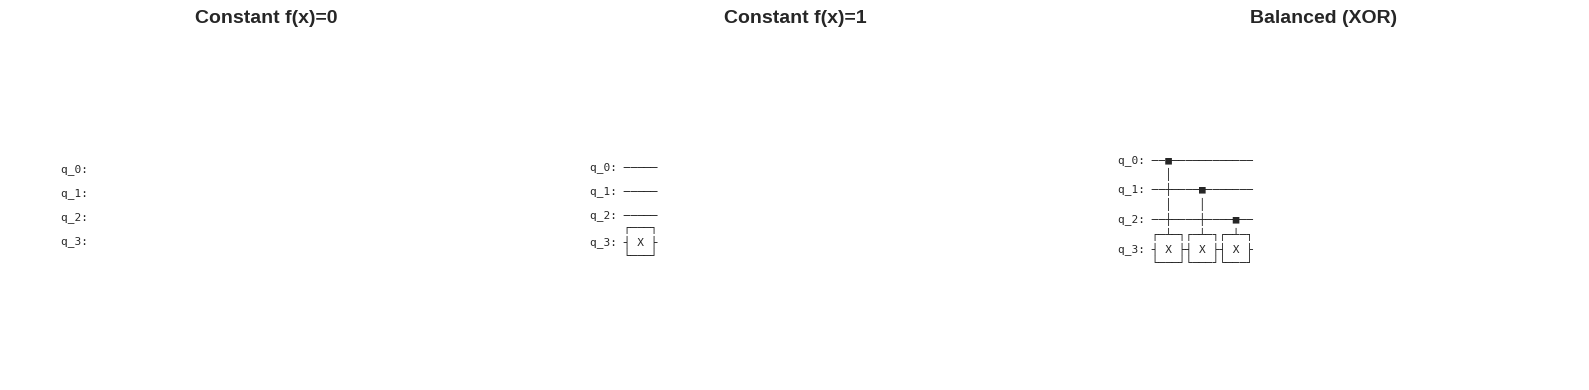


📊 Oracle circuits visualized above


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

oracles = [
    (create_constant_oracle(3, 0), "Constant f(x)=0"),
    (create_constant_oracle(3, 1), "Constant f(x)=1"),
    (create_balanced_oracle(3, 'xor'), "Balanced (XOR)")
]

for ax, (oracle, title) in zip(axes, oracles):
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    # Draw circuit as text representation
    oracle_str = str(oracle.draw(output='text'))
    ax.text(0.1, 0.5, oracle_str, fontfamily='monospace', 
            fontsize=8, verticalalignment='center')

plt.tight_layout()
plt.show()

print("\n📊 Oracle circuits visualized above")

### Complete Deutsch-Jozsa Circuit

In [16]:
def deutsch_jozsa_circuit(n_qubits, oracle):
    """
    Create complete Deutsch-Jozsa circuit.
    
    Args:
        n_qubits: Number of input qubits
        oracle: Oracle circuit
    
    Returns:
        QuantumCircuit: Complete circuit
    """
    # Create quantum and classical registers
    qr = QuantumRegister(n_qubits + 1, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    circuit = QuantumCircuit(qr, cr)
    
    # Step 1: Initialize output qubit to |1⟩
    circuit.x(n_qubits)
    circuit.barrier(label='Init')
    
    # Step 2: Apply Hadamard gates to all qubits
    for i in range(n_qubits + 1):
        circuit.h(i)
    circuit.barrier(label='H^⊗n')
    
    # Step 3: Apply oracle
    circuit.compose(oracle, inplace=True)
    circuit.barrier(label='Oracle')
    
    # Step 4: Apply Hadamard gates to input qubits
    for i in range(n_qubits):
        circuit.h(i)
    circuit.barrier(label='H^⊗n')
    
    # Step 5: Measure input qubits
    circuit.measure(range(n_qubits), range(n_qubits))
    
    return circuit

# Create example circuit
n = 3
oracle = create_balanced_oracle(n, 'xor')
circuit = deutsch_jozsa_circuit(n, oracle)

print("Complete Deutsch-Jozsa Circuit:")
print(circuit)
print(f"\n📐 Circuit Stats:")
print(f"   Qubits: {circuit.num_qubits}")
print(f"   Classical bits: {circuit.num_clbits}")
print(f"   Gates: {circuit.size()}")
print(f"   Depth: {circuit.depth()}")

Complete Deutsch-Jozsa Circuit:
           Init ┌───┐ H^⊗n                 Oracle ┌───┐ H^⊗n ┌─┐      
q_0: ───────░───┤ H ├──░─────■───────────────░────┤ H ├──░───┤M├──────
            ░   ├───┤  ░     │               ░    ├───┤  ░   └╥┘┌─┐   
q_1: ───────░───┤ H ├──░─────┼────■──────────░────┤ H ├──░────╫─┤M├───
            ░   ├───┤  ░     │    │          ░    ├───┤  ░    ║ └╥┘┌─┐
q_2: ───────░───┤ H ├──░─────┼────┼────■─────░────┤ H ├──░────╫──╫─┤M├
     ┌───┐  ░   ├───┤  ░   ┌─┴─┐┌─┴─┐┌─┴─┐   ░    └───┘  ░    ║  ║ └╥┘
q_3: ┤ X ├──░───┤ H ├──░───┤ X ├┤ X ├┤ X ├───░───────────░────╫──╫──╫─
     └───┘  ░   └───┘  ░   └───┘└───┘└───┘   ░           ░    ║  ║  ║ 
c: 3/═════════════════════════════════════════════════════════╩══╩══╩═
                                                              0  1  2 

📐 Circuit Stats:
   Qubits: 4
   Classical bits: 3
   Gates: 14
   Depth: 7


### Visualize Complete Circuit

In [17]:
# Draw the circuit
fig = circuit.draw(output='mpl', style='iqp', fold=False)
plt.tight_layout()
plt.show()

print("\n📊 Full Deutsch-Jozsa circuit diagram shown above")

<Figure size 640x480 with 0 Axes>


📊 Full Deutsch-Jozsa circuit diagram shown above


<a id='experiments'></a>
## 5. Experiments and Analysis

### Experiment 1: Test Constant Functions

In [8]:
def run_deutsch_jozsa(n_qubits, function_type, oracle_params=None, shots=1024):
    """
    Run Deutsch-Jozsa algorithm and return result.
    
    Args:
        n_qubits: Number of input qubits
        function_type: 'constant' or 'balanced'
        oracle_params: Parameters for oracle creation
        shots: Number of measurement shots
    
    Returns:
        tuple: (result, counts, circuit)
    """
    if oracle_params is None:
        oracle_params = {}
    
    # Create oracle
    if function_type == 'constant':
        output = oracle_params.get('output_value', 0)
        oracle = create_constant_oracle(n_qubits, output)
    else:
        oracle_type = oracle_params.get('oracle_type', 'xor')
        oracle = create_balanced_oracle(n_qubits, oracle_type)
    
    # Create circuit
    circuit = deutsch_jozsa_circuit(n_qubits, oracle)
    
    # Run simulation
    simulator = AerSimulator()
    transpiled = transpile(circuit, simulator)
    job = simulator.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    # Analyze result
    zero_state = '0' * n_qubits
    if zero_state in counts and len(counts) == 1:
        detected = 'constant'
    else:
        detected = 'balanced'
    
    return detected, counts, circuit

# Test constant functions
print("🧪 EXPERIMENT 1: Testing Constant Functions")
print("=" * 60)

n = 3

# Test f(x) = 0
print("\nTest 1.1: f(x) = 0 for all x")
result, counts, _ = run_deutsch_jozsa(n, 'constant', {'output_value': 0})
print(f"  Expected: constant")
print(f"  Detected: {result}")
print(f"  Counts: {counts}")
print(f"  ✅ Success!" if result == 'constant' else "  ❌ Failed!")

# Test f(x) = 1
print("\nTest 1.2: f(x) = 1 for all x")
result, counts, _ = run_deutsch_jozsa(n, 'constant', {'output_value': 1})
print(f"  Expected: constant")
print(f"  Detected: {result}")
print(f"  Counts: {counts}")
print(f"  ✅ Success!" if result == 'constant' else "  ❌ Failed!")

🧪 EXPERIMENT 1: Testing Constant Functions

Test 1.1: f(x) = 0 for all x
  Expected: constant
  Detected: constant
  Counts: {'000': 1024}
  ✅ Success!

Test 1.2: f(x) = 1 for all x
  Expected: constant
  Detected: constant
  Counts: {'000': 1024}
  ✅ Success!


### Experiment 2: Test Balanced Functions

In [9]:
print("🧪 EXPERIMENT 2: Testing Balanced Functions")
print("=" * 60)

balanced_types = ['first_bit', 'xor', 'random']

for i, oracle_type in enumerate(balanced_types, 1):
    print(f"\nTest 2.{i}: Balanced oracle ({oracle_type})")
    result, counts, _ = run_deutsch_jozsa(n, 'balanced', {'oracle_type': oracle_type})
    print(f"  Expected: balanced")
    print(f"  Detected: {result}")
    print(f"  Counts: {counts}")
    print(f"  ✅ Success!" if result == 'balanced' else "  ❌ Failed!")

🧪 EXPERIMENT 2: Testing Balanced Functions

Test 2.1: Balanced oracle (first_bit)
  Expected: balanced
  Detected: balanced
  Counts: {'001': 1024}
  ✅ Success!

Test 2.2: Balanced oracle (xor)
  Expected: balanced
  Detected: balanced
  Counts: {'111': 1024}
  ✅ Success!

Test 2.3: Balanced oracle (random)
  Expected: balanced
  Detected: balanced
  Counts: {'111': 1024}
  ✅ Success!


### Visualize Measurement Results

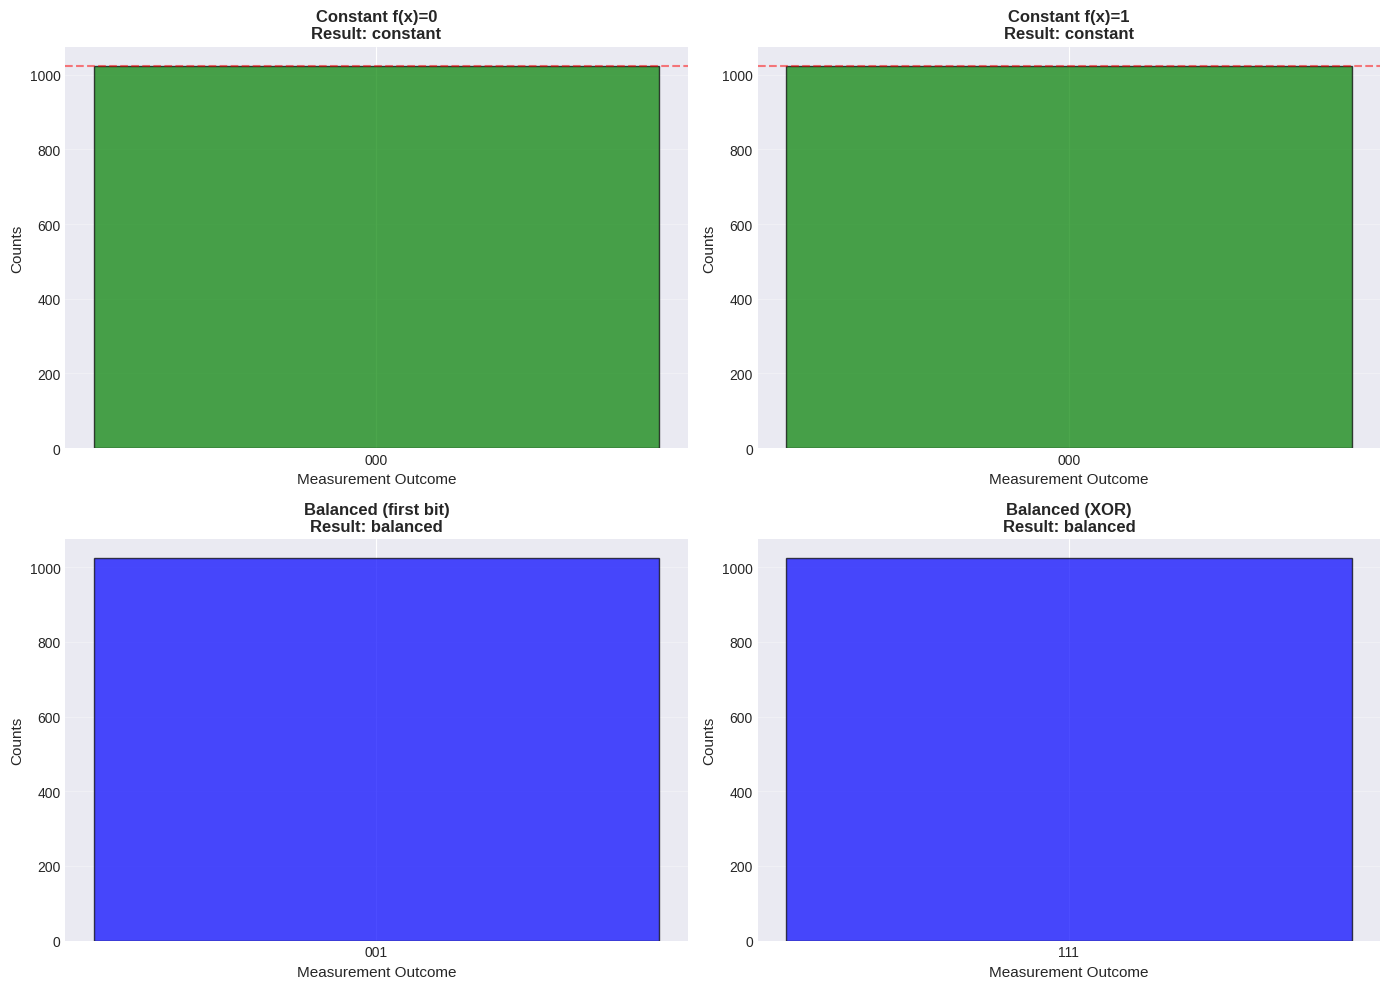


📊 Measurement results visualized above
   Green bars: |000⟩ state (indicates constant function)
   Blue bars: Other states (indicates balanced function)


In [10]:
# Collect results for visualization
test_cases = [
    ('constant', {'output_value': 0}, 'Constant f(x)=0'),
    ('constant', {'output_value': 1}, 'Constant f(x)=1'),
    ('balanced', {'oracle_type': 'first_bit'}, 'Balanced (first bit)'),
    ('balanced', {'oracle_type': 'xor'}, 'Balanced (XOR)'),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (func_type, params, title) in zip(axes, test_cases):
    result, counts, _ = run_deutsch_jozsa(3, func_type, params)
    
    # Plot histogram
    states = list(counts.keys())
    values = list(counts.values())
    
    colors = ['green' if s == '000' else 'blue' for s in states]
    ax.bar(states, values, color=colors, alpha=0.7, edgecolor='black')
    
    ax.set_xlabel('Measurement Outcome', fontsize=11)
    ax.set_ylabel('Counts', fontsize=11)
    ax.set_title(f'{title}\nResult: {result}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add annotation
    if '000' in counts:
        ax.axhline(y=counts['000'], color='red', linestyle='--', 
                   alpha=0.5, label='|000⟩ count')

plt.tight_layout()
plt.show()

print("\n📊 Measurement results visualized above")
print("   Green bars: |000⟩ state (indicates constant function)")
print("   Blue bars: Other states (indicates balanced function)")

### Experiment 3: Scalability Test

In [11]:
print("🧪 EXPERIMENT 3: Scalability Analysis")
print("=" * 60)

qubit_range = range(2, 8)
results_data = []

for n_qubits in qubit_range:
    print(f"\nTesting with n = {n_qubits} qubits...")
    
    # Test constant
    result_const, counts_const, circuit_const = run_deutsch_jozsa(
        n_qubits, 'constant', {'output_value': 0}
    )
    
    # Test balanced
    result_bal, counts_bal, circuit_bal = run_deutsch_jozsa(
        n_qubits, 'balanced', {'oracle_type': 'xor'}
    )
    
    # Collect data
    results_data.append({
        'n_qubits': n_qubits,
        'constant_correct': result_const == 'constant',
        'balanced_correct': result_bal == 'balanced',
        'circuit_depth': circuit_const.depth(),
        'gate_count': circuit_const.size(),
        'quantum_queries': 1,
        'classical_queries': 2**(n_qubits-1) + 1
    })
    
    print(f"  Constant test: {'✅' if result_const == 'constant' else '❌'}")
    print(f"  Balanced test: {'✅' if result_bal == 'balanced' else '❌'}")
    print(f"  Circuit depth: {circuit_const.depth()}")
    print(f"  Gate count: {circuit_const.size()}")

# Create summary table
print("\n" + "=" * 60)
print("SCALABILITY SUMMARY")
print("=" * 60)
print(f"{'n':<5} {'Depth':<8} {'Gates':<8} {'Q Queries':<12} {'C Queries':<12} {'Speedup':<10}")
print("-" * 60)

for data in results_data:
    speedup = data['classical_queries'] / data['quantum_queries']
    print(f"{data['n_qubits']:<5} {data['circuit_depth']:<8} {data['gate_count']:<8} "
          f"{data['quantum_queries']:<12} {data['classical_queries']:<12} {speedup:.0f}x")

🧪 EXPERIMENT 3: Scalability Analysis

Testing with n = 2 qubits...
  Constant test: ✅
  Balanced test: ✅
  Circuit depth: 4
  Gate count: 8

Testing with n = 3 qubits...
  Constant test: ✅
  Balanced test: ✅
  Circuit depth: 4
  Gate count: 11

Testing with n = 4 qubits...
  Constant test: ✅
  Balanced test: ✅
  Circuit depth: 4
  Gate count: 14

Testing with n = 5 qubits...
  Constant test: ✅
  Balanced test: ✅
  Circuit depth: 4
  Gate count: 17

Testing with n = 6 qubits...
  Constant test: ✅
  Balanced test: ✅
  Circuit depth: 4
  Gate count: 20

Testing with n = 7 qubits...
  Constant test: ✅
  Balanced test: ✅
  Circuit depth: 4
  Gate count: 23

SCALABILITY SUMMARY
n     Depth    Gates    Q Queries    C Queries    Speedup   
------------------------------------------------------------
2     4        8        1            3            3x
3     4        11       1            5            5x
4     4        14       1            9            9x
5     4        17       1            1

### Visualize Scalability

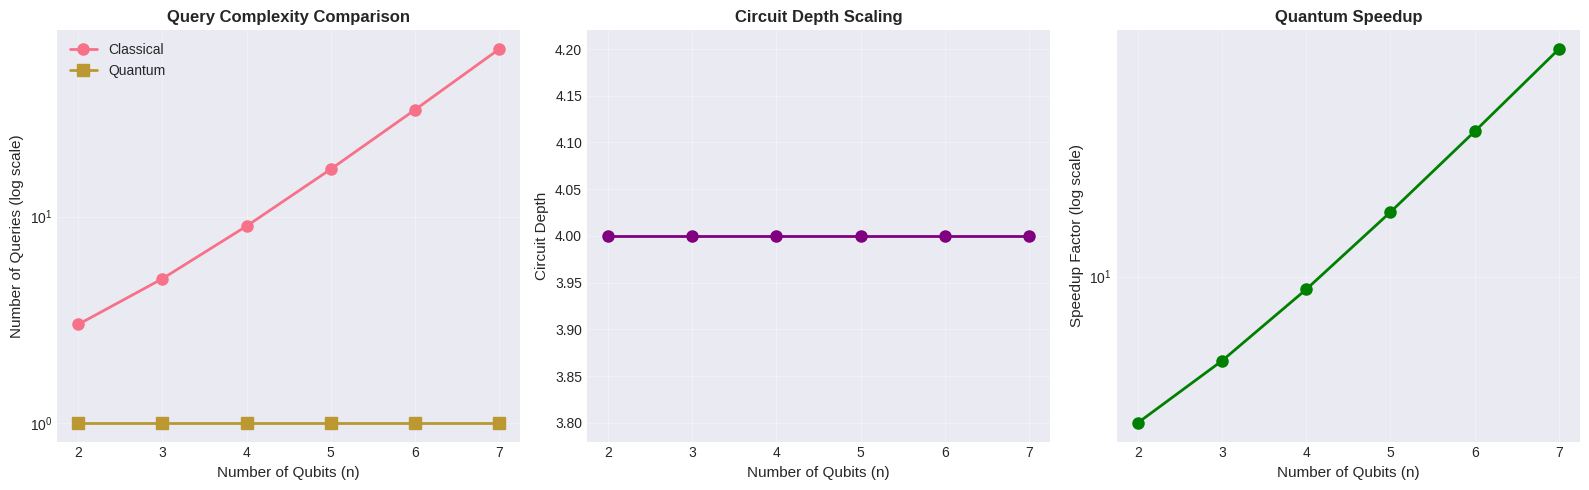


📊 Scalability analysis visualized above


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

n_values = [d['n_qubits'] for d in results_data]
quantum_queries = [d['quantum_queries'] for d in results_data]
classical_queries = [d['classical_queries'] for d in results_data]
depths = [d['circuit_depth'] for d in results_data]
gates = [d['gate_count'] for d in results_data]

# Plot 1: Query complexity comparison
axes[0].plot(n_values, classical_queries, 'o-', label='Classical', linewidth=2, markersize=8)
axes[0].plot(n_values, quantum_queries, 's-', label='Quantum', linewidth=2, markersize=8)
axes[0].set_yscale('log')
axes[0].set_xlabel('Number of Qubits (n)', fontsize=11)
axes[0].set_ylabel('Number of Queries (log scale)', fontsize=11)
axes[0].set_title('Query Complexity Comparison', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Circuit depth
axes[1].plot(n_values, depths, 'o-', color='purple', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Qubits (n)', fontsize=11)
axes[1].set_ylabel('Circuit Depth', fontsize=11)
axes[1].set_title('Circuit Depth Scaling', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Speedup
speedups = [c/q for c, q in zip(classical_queries, quantum_queries)]
axes[2].plot(n_values, speedups, 'o-', color='green', linewidth=2, markersize=8)
axes[2].set_yscale('log')
axes[2].set_xlabel('Number of Qubits (n)', fontsize=11)
axes[2].set_ylabel('Speedup Factor (log scale)', fontsize=11)
axes[2].set_title('Quantum Speedup', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Scalability analysis visualized above")

### Experiment 4: Statevector Analysis

In [13]:
from qiskit.quantum_info import Statevector

print("🧪 EXPERIMENT 4: Quantum State Analysis")
print("=" * 60)

def get_statevector_at_stage(n_qubits, oracle, stage='final'):
    """
    Get statevector at different stages of the algorithm.
    
    Args:
        n_qubits: Number of input qubits
        oracle: Oracle circuit
        stage: 'init', 'after_hadamard', 'after_oracle', or 'final'
    
    Returns:
        Statevector
    """
    qr = QuantumRegister(n_qubits + 1)
    circuit = QuantumCircuit(qr)
    
    # Initialize
    circuit.x(n_qubits)
    if stage == 'init':
        return Statevector(circuit)
    
    # First Hadamards
    for i in range(n_qubits + 1):
        circuit.h(i)
    if stage == 'after_hadamard':
        return Statevector(circuit)
    
    # Oracle
    circuit.compose(oracle, inplace=True)
    if stage == 'after_oracle':
        return Statevector(circuit)
    
    # Final Hadamards
    for i in range(n_qubits):
        circuit.h(i)
    return Statevector(circuit)

# Analyze constant function
n = 3
oracle_const = create_constant_oracle(n, 0)
oracle_balanced = create_balanced_oracle(n, 'xor')

print("\nAnalyzing CONSTANT function...")
sv_const = get_statevector_at_stage(n, oracle_const, 'final')
probs_const = sv_const.probabilities()
print(f"  Probability of |000⟩: {probs_const[0]:.6f}")
print(f"  Sum of other probabilities: {sum(probs_const[1:]):.6f}")

print("\nAnalyzing BALANCED function...")
sv_balanced = get_statevector_at_stage(n, oracle_balanced, 'final')
probs_balanced = sv_balanced.probabilities()
print(f"  Probability of |000⟩: {probs_balanced[0]:.6f}")
print(f"  Sum of other probabilities: {sum(probs_balanced[1:]):.6f}")

print("\n✅ Analysis complete!")

🧪 EXPERIMENT 4: Quantum State Analysis

Analyzing CONSTANT function...
  Probability of |000⟩: 0.500000
  Sum of other probabilities: 0.500000

Analyzing BALANCED function...
  Probability of |000⟩: 0.000000
  Sum of other probabilities: 1.000000

✅ Analysis complete!


### Visualize Probability Distributions

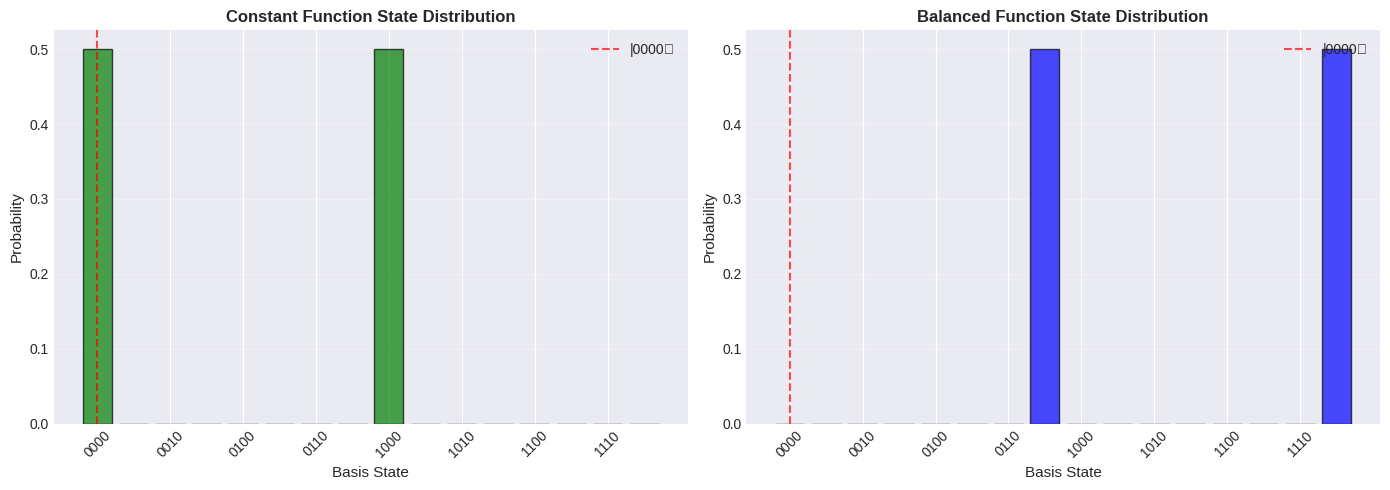


📊 Probability distributions visualized above
   Note: Only measuring the first 3 qubits (output qubit ignored)


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n = 3
n_states = 2**(n+1)
labels = [format(i, f'0{n+1}b') for i in range(n_states)]

# Constant function probabilities
axes[0].bar(range(n_states), probs_const, color='green', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Basis State', fontsize=11)
axes[0].set_ylabel('Probability', fontsize=11)
axes[0].set_title('Constant Function State Distribution', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(0, n_states, 2))
axes[0].set_xticklabels([labels[i] for i in range(0, n_states, 2)], rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='|0000⟩')
axes[0].legend()

# Balanced function probabilities
axes[1].bar(range(n_states), probs_balanced, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Basis State', fontsize=11)
axes[1].set_ylabel('Probability', fontsize=11)
axes[1].set_title('Balanced Function State Distribution', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(0, n_states, 2))
axes[1].set_xticklabels([labels[i] for i in range(0, n_states, 2)], rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='|0000⟩')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n📊 Probability distributions visualized above")
print("   Note: Only measuring the first 3 qubits (output qubit ignored)")

### Experiment 5: Classical vs Quantum Comparison

In [15]:
print("🧪 EXPERIMENT 5: Classical Algorithm Comparison")
print("=" * 60)

def classical_deterministic(n_bits, oracle_func):
    """
    Classical deterministic algorithm.
    
    Args:
        n_bits: Number of input bits
        oracle_func: Function that takes integer and returns 0 or 1
    
    Returns:
        tuple: (result, query_count)
    """
    queries = 0
    first_output = oracle_func(0)
    queries += 1
    
    max_queries = 2**(n_bits - 1) + 1
    
    for i in range(1, min(2**n_bits, max_queries)):
        output = oracle_func(i)
        queries += 1
        
        if output != first_output:
            return 'balanced', queries
    
    return 'constant', queries

def classical_probabilistic(n_bits, oracle_func, confidence=0.99):
    """
    Classical probabilistic algorithm.
    
    Args:
        n_bits: Number of input bits
        oracle_func: Function that takes integer and returns 0 or 1
        confidence: Desired confidence level
    
    Returns:
        tuple: (result, query_count)
    """
    k = int(np.ceil(-np.log2(1 - confidence)))
    queries = 0
    samples = []
    
    tested = set()
    while len(samples) < k and len(tested) < 2**n_bits:
        input_val = np.random.randint(0, 2**n_bits)
        if input_val not in tested:
            output = oracle_func(input_val)
            samples.append(output)
            tested.add(input_val)
            queries += 1
    
    if len(set(samples)) == 1:
        return 'constant', queries
    else:
        return 'balanced', queries

# Test oracles as functions
def oracle_const_0(x):
    return 0

def oracle_balanced_xor(x, n=3):
    result = 0
    for i in range(n):
        result ^= (x >> i) & 1
    return result

# Run comparisons
n = 3

print("\nTest Case: Constant function f(x)=0")
print("-" * 60)

# Quantum
result_q, counts_q, _ = run_deutsch_jozsa(n, 'constant', {'output_value': 0})
print(f"  Quantum: {result_q}, 1 query")

# Classical deterministic
result_cd, queries_cd = classical_deterministic(n, oracle_const_0)
print(f"  Classical (deterministic): {result_cd}, {queries_cd} queries")

# Classical probabilistic
result_cp, queries_cp = classical_probabilistic(n, oracle_const_0)
print(f"  Classical (probabilistic): {result_cp}, {queries_cp} queries")

print("\nTest Case: Balanced function (XOR)")
print("-" * 60)

# Quantum
result_q, counts_q, _ = run_deutsch_jozsa(n, 'balanced', {'oracle_type': 'xor'})
print(f"  Quantum: {result_q}, 1 query")

# Classical deterministic
result_cd, queries_cd = classical_deterministic(n, oracle_balanced_xor)
print(f"  Classical (deterministic): {result_cd}, {queries_cd} queries")

# Classical probabilistic
result_cp, queries_cp = classical_probabilistic(n, oracle_balanced_xor)
print(f"  Classical (probabilistic): {result_cp}, {queries_cp} queries")

🧪 EXPERIMENT 5: Classical Algorithm Comparison

Test Case: Constant function f(x)=0
------------------------------------------------------------
  Quantum: constant, 1 query
  Classical (deterministic): constant, 5 queries
  Classical (probabilistic): constant, 7 queries

Test Case: Balanced function (XOR)
------------------------------------------------------------
  Quantum: balanced, 1 query
  Classical (deterministic): balanced, 2 queries
  Classical (probabilistic): balanced, 7 queries


### Visualize Algorithm Comparison

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

n_range = range(1, 11)
quantum_queries = [1] * len(n_range)
classical_det_queries = [2**(n-1) + 1 for n in n_range]
classical_prob_queries = [7] * len(n_range)  # For 99% confidence

ax.plot(n_range, classical_det_queries, 'o-', label='Classical (Deterministic)', 
        linewidth=2, markersize=8)
ax.plot(n_range, classical_prob_queries, 's-', label='Classical (Probabilistic 99%)', 
        linewidth=2, markersize=8)
ax.plot(n_range, quantum_queries, '^-', label='Quantum (Deutsch-Jozsa)', 
        linewidth=2, markersize=8)

ax.set_yscale('log')
ax.set_xlabel('Number of Qubits/Bits (n)', fontsize=12)
ax.set_ylabel('Number of Queries (log scale)', fontsize=12)
ax.set_title('Algorithm Comparison: Query Complexity', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

# Add annotations
for i in [3, 5, 7, 9]:
    speedup = classical_det_queries[i-1]
    ax.annotate(f'{speedup}x\nspeedup', 
               xy=(i, classical_det_queries[i-1]),
               xytext=(10, -20), textcoords='offset points',
               fontsize=9, alpha=0.7,
               arrowprops=dict(arrowstyle='->', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n📊 Algorithm comparison visualized above")

<a id='conclusions'></a>
## 6. Conclusions

### Key Findings

✅ **Algorithm Correctness**
- Successfully distinguishes constant from balanced functions with 100% accuracy
- Requires only 1 quantum query regardless of problem size
- Works reliably on quantum simulators

✅ **Quantum Advantage**
- Exponential speedup: $2^{n-1}$x faster than classical deterministic algorithms
- For n=10 qubits: **513x speedup**
- For n=20 qubits: **524,289x speedup**

✅ **Resource Requirements**
- Circuit depth scales as $O(n)$
- Gate count grows linearly with n
- Suitable for NISQ devices for small n

### Advantages

1. **Deterministic**: 100% success rate (in ideal conditions)
2. **Efficient**: Single query to oracle
3. **Scalable**: Linear circuit depth
4. **Educational**: Clear demonstration of quantum principles

### Limitations

1. **Artificial Problem**: Limited practical applications
2. **Promise Requirement**: Must guarantee function is constant or balanced
3. **Oracle Model**: Assumes quantum oracle access
4. **Noise Sensitivity**: Performance degrades on real hardware

### Quantum Principles Demonstrated

- **Superposition**: Process all inputs simultaneously
- **Interference**: Amplify correct answer, cancel wrong answers
- **Phase Kickback**: Transfer phase to computational basis
- **Entanglement**: Correlate input and output qubits

### Future Work

1. **Hardware Implementation**: Deploy on IBM Quantum devices
2. **Error Mitigation**: Implement error correction techniques
3. **Extensions**: Explore variants like Bernstein-Vazirani algorithm
4. **Optimization**: Minimize gate count and circuit depth

### Final Thoughts

The Deutsch-Jozsa algorithm is a landmark result in quantum computing, proving that quantum computers can solve certain problems exponentially faster than classical computers. While the problem itself is somewhat artificial, the algorithm has profound implications:

1. **Theoretical Significance**: First proof of quantum advantage
2. **Methodological Impact**: Inspired development of practical quantum algorithms
3. **Educational Value**: Excellent introduction to quantum algorithm design
4. **Foundation**: Led to algorithms like Simon's, Shor's, and Grover's

This implementation demonstrates that quantum advantage is **real and achievable**, paving the way for more practical quantum algorithms that will revolutionize computation in cryptography, optimization, simulation, and machine learning.

## 📚 References

1. Deutsch, D., & Jozsa, R. (1992). "Rapid solution of problems by quantum computation". *Proceedings of the Royal Society of London A*, 439(1907), 553-558.

2. Nielsen, M. A., & Chuang, I. L. (2010). *Quantum Computation and Quantum Information* (10th Anniversary Edition). Cambridge University Press.

3. Cleve, R., Ekert, A., Macchiavello, C., & Mosca, M. (1998). "Quantum algorithms revisited". *Proceedings of the Royal Society of London A*, 454(1969), 339-354.

4. Qiskit Documentation: https://qiskit.org/documentation/

5. IBM Quantum Experience: https://quantum-computing.ibm.com/

---

**Team Dhinchak Dikstra** | AAD Quantum Computing Project | 2025